In [32]:
!pip install git+https://github.com/andreinechaev/nvcc4jupyter.git
%load_ext nvcc_plugin
!nvcc --version
!nvidia-smi

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/andreinechaev/nvcc4jupyter.git to /tmp/pip-req-build-fxxe7n3h
  Running command git clone --filter=blob:none --quiet https://github.com/andreinechaev/nvcc4jupyter.git /tmp/pip-req-build-fxxe7n3h
  Resolved https://github.com/andreinechaev/nvcc4jupyter.git to commit aac710a35f52bb78ab34d2e52517237941399eff
  Preparing metadata (setup.py) ... done
The nvcc_plugin extension is already loaded. To reload it, use:
  %reload_ext nvcc_plugin
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Wed_Sep_21_10:33:58_PDT_2022
Cuda compilation tools, release 11.8, V11.8.89
Build cuda_11.8.r11.8/compiler.31833905_0
Tue Apr 25 17:34:56 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+-

In [46]:
%%cuda --name r3_parallel.cu

// We will only be using static arrays in this
#include <cuda.h>
#include <cuda_runtime.h>
#include <math.h>
#include <iostream>
#include <fstream>
#include <string>

const double INF_ = 1e9;
const double epsilon = 0.0000000001;

struct ii {
    int F;
    int S;
};

__device__ double calc_dist(ii p1, ii p2){
    double x1 = p1.F; double y1 = p1.S;
    double x2 = p2.F; double y2 = p2.S;
    double dx = x2-x1; double dy = y2-y1;
    return sqrt((dx*dx) + (dy*dy));
}


__device__ bool isvalid(ii p, int n, int m, double dist_from_origin, double range){
    if(p.F < 0 || p.S < 0) return 0;
    if(p.F >= n || p.S >= m) return 0;
    if(dist_from_origin > range) return 0;
    return 1;
}


__device__ double find_slope(int *grid, ii observer, ii curr, int observer_ht, int n, int m){
    double dist = calc_dist(observer, curr);
    int id_curr = (curr.F)*(m) + (curr.S);
    int id_obs = (observer.F)*(m) + (observer.S);
    double dh = double(grid[id_curr]) - (double(grid[id_obs]) + (double)observer_ht);
    double m_curr = dh/dist;
    return m_curr;
}


__device__  void plotPixel(ii *line, int &numpts, int x1, int y1, int x2, int y2, int dx, int dy, int decide, int lid_add){
    int pk = 2 * dy - dx;
    numpts = 0; 

    for (int i = 0; i <= dx; i++) {
        x1 < x2 ? x1++ : x1--;
        if (pk < 0) {
            if (decide == 0) {
                ii temp = {x1,y1};
                line[lid_add+numpts] = temp;
                numpts++;
                pk = pk + 2 * dy;
            }
            else {
                ii temp = {y1,x1};
                line[lid_add+numpts] = temp;
                numpts++;
                pk = pk + 2 * dy;
            }
        }
        else {
            y1 < y2 ? y1++ : y1--;
            if (decide == 0) {
                ii temp = {x1,y1};
                line[lid_add+numpts] = temp;
                numpts++;
            }
            else {
                ii temp = {y1,x1};
                line[lid_add+numpts] = temp;
                numpts++;
            }
            pk = pk + 2 * dy - 2 * dx;
        }
    }
}


__device__ void bresenham(ii *line_grid, int &numpts, int x1, int y1, int x2, int y2, int lid_add){
    int dx = abs(x2 - x1);
    int dy = abs(y2 - y1);
    numpts=0;
    if(dx > dy){
        plotPixel(line_grid, numpts, x1, y1, x2, y2, dx, dy, 0, lid_add);
    }
    else{
        plotPixel(line_grid, numpts, y1, x1, y2, x2, dy, dx, 1, lid_add);
    }
}


void readfile_and_make_grid(int* grid, int &n, int &m){
    //std::ifstream infile("/Users/avirajbevli/Desktop/Sem10/HPPP/cuda_term project/data/cdnf43w/heights.txt");
    std::cout<<"Reading from input file..."<<std::endl;
    std::ifstream infile("heights.txt");
    if(!infile.is_open()) {
        printf("not abel to read \n");
        std::cerr << "Error: Could not open read file" << std::endl;
        return  ;
    }

    std::string line;
    n=0;
    int numpts=0;
    while(std::getline(infile, line)) {
        std::string str; 
        int i=0;
        while(i<line.size()){
            if(line[i]==','){
                int temp = stoi(str);
                grid[numpts++] = temp;
                str="";
                i++;
            }
            else{
                str+=line[i];
            }
            i++;
        }
        n++;
    }
    m = (numpts)/n;
    infile.close();
    std::cout<<"Done reading \n"<<std::endl;
}


// cant rely on print in global
__global__ void test_kernel(int *viewshed_d, int *grid_d){
    viewshed_d[0]=999;
    grid_d[0]=999;
}

// -1: out of range, 0: not visible, 2: visible
// can not print anything inside global/device functions
__global__ void calculate_viewshed_and_writefile_r3(int *grid, int* viewshed, ii *line_grid, int n, int m, int range){    
    // viewshed[0]=999;
    // grid[0]=999;

    int obsy = 1000; int obsx = 3000;
    ii observer = {obsy, obsx}; //<y,x> or <row,col>
    int observer_ht = 10; // height of observer from the ground at <observer_x, observer_y>  

    int I = observer.F + (blockIdx.y * blockDim.y + threadIdx.y - range); 
    int J = observer.S + (blockIdx.x * blockDim.x + threadIdx.x - range);
    if(I>=0 && J>=0 && I<n && J<m){
        ii target = {I,J};
        int index = (target.F)*(m) + (target.S);
        viewshed[index]=2;
        __syncthreads(); // no need for this, right?
        
        double m_target = find_slope(grid, observer, target, observer_ht, n, m); 

        int linesz=0;
        int tempy = blockIdx.y * blockDim.y + threadIdx.y;
        int tempx = blockIdx.x * blockDim.x + threadIdx.x;
        int lid_add = (tempy*(2*range + 1) + tempx)*(2*range); // range
        bresenham(line_grid, linesz, observer.F, observer.S, target.F, target.S, lid_add);

        // printf("I:%d, J:%d, linesz:%d \n", I, J, linesz);
        double m_max = -INF_;
        for(int lid=1;lid<linesz-1;lid++){
            double m_curr = find_slope(grid, observer, line_grid[lid_add+lid], observer_ht, n, m);
            m_max = max(m_max, m_curr);
        }
        if(m_max > m_target + epsilon){
            viewshed[index]=0;
        }
        __syncthreads(); // so that the viewshed is complete
    }
}


__global__ void calculate_viewshed_and_writefile_r3_kernel2(int *grid, int* viewshed, ii *line_grid, int n, int m, int range){    
    // viewshed[0]=999;
    // grid[0]=999;

    int obsy = 1000; int obsx = 3000;
    ii observer = {obsy, obsx}; //<y,x> or <row,col>
    int observer_ht = 10; // height of observer from the ground at <observer_x, observer_y>  

    int I = observer.F + (blockIdx.y * blockDim.y + threadIdx.y - range); 
    int J = observer.S + (blockIdx.x * blockDim.x + threadIdx.x - range);
    if(I>=0 && J>=0 && I<n && J<m){
        ii target = {I,J};
        int index = (target.F)*(m) + (target.S);
        viewshed[index]=1;
        __syncthreads(); // no need for this, right?
        
        double m_target = find_slope(grid, observer, target, observer_ht, n, m); 

        int linesz=0;
        int tempy = blockIdx.y * blockDim.y + threadIdx.y;
        int tempx = blockIdx.x * blockDim.x + threadIdx.x;
        int lid_add = (tempy*(2*range + 1) + tempx)*(2*range); // range
        bresenham(line_grid, linesz, observer.F, observer.S, target.F, target.S, lid_add);

        // printf("I:%d, J:%d, linesz:%d \n", I, J, linesz);
        double m_max = -INF_;
        for(int lid=1;lid<linesz-1;lid++){
            double m_curr = find_slope(grid, observer, line_grid[lid_add+lid], observer_ht, n, m);
            m_max = max(m_max, m_curr);
        }
        if(m_max > m_target + epsilon){
            if(viewshed[index]!=2){
                viewshed[index]=0;
            }
        }
        else{
            viewshed[index]=2;
        }
        __syncthreads(); // so that the viewshed is complete
    }
}


__global__ void r3_fused_inner_thread(int *grid, int* viewshed, ii *line_grid, int n, int m, int range){    
    int obsy = 1000; int obsx = 3000;
    int obsy2 = 800; int obsx2 = 2400;
    ii observer = {obsy, obsx}; //<y,x> or <row,col>
    ii observer2 = {obsy2, obsx2}; //<y,x> or <row,col>
    int observer_ht = 10; // height of observer from the ground at <observer_x, observer_y>  

    int I = observer.F + (blockIdx.y * blockDim.y + threadIdx.y - range); 
    int J = observer.S + (blockIdx.x * blockDim.x + threadIdx.x - range);
    if(I>=0 && J>=0 && I<n && J<m){
        ii target = {I,J};
        int index = (target.F)*(m) + (target.S);
        viewshed[index]=1;
        __syncthreads(); // no need for this, right?
        
        double m_target = find_slope(grid, observer, target, observer_ht, n, m); 

        int linesz=0;
        int tempy = blockIdx.y * blockDim.y + threadIdx.y;
        int tempx = blockIdx.x * blockDim.x + threadIdx.x;
        int lid_add = (tempy*(2*range + 1) + tempx)*(2*range); // range
        bresenham(line_grid, linesz, observer.F, observer.S, target.F, target.S, lid_add);

        // printf("I:%d, J:%d, linesz:%d \n", I, J, linesz);
        double m_max = -INF_;
        for(int lid=1;lid<linesz-1;lid++){
            double m_curr = find_slope(grid, observer, line_grid[lid_add+lid], observer_ht, n, m);
            m_max = max(m_max, m_curr);
        }
        if(m_max > m_target + epsilon){
            if(viewshed[index]!=2){
                viewshed[index]=0;
            }
        }
        else{
            viewshed[index]=2;
        }
        __syncthreads(); // so that the viewshed is complete
    }

    I = observer2.F + (blockIdx.y * blockDim.y + threadIdx.y - range); 
    J = observer2.S + (blockIdx.x * blockDim.x + threadIdx.x - range);
    if(I>=0 && J>=0 && I<n && J<m){
        ii target = {I,J};
        int index = (target.F)*(m) + (target.S);
        viewshed[index]=1;
        __syncthreads(); // no need for this, right?
        
        double m_target = find_slope(grid, observer2, target, observer_ht, n, m); 

        int linesz=0;
        int tempy = blockIdx.y * blockDim.y + threadIdx.y;
        int tempx = blockIdx.x * blockDim.x + threadIdx.x;
        int lid_add = (tempy*(2*range + 1) + tempx)*(2*range); // range
        bresenham(line_grid, linesz, observer2.F, observer2.S, target.F, target.S, lid_add);

        // printf("I:%d, J:%d, linesz:%d \n", I, J, linesz);
        double m_max = -INF_;
        for(int lid=1;lid<linesz-1;lid++){
            double m_curr = find_slope(grid, observer2, line_grid[lid_add+lid], observer_ht, n, m);
            m_max = max(m_max, m_curr);
        }
        if(m_max > m_target + epsilon){
            if(viewshed[index]!=2){
                viewshed[index]=0;
            }
        }
        else{
            viewshed[index]=2;
        }
        __syncthreads(); // so that the viewshed is complete
    }
}


__global__ void r3_fused_inner_block(int *grid, int* viewshed, ii *line_grid, int n, int m, int range){    
    int obsy1 = 1000; int obsx1 = 3000;
    int obsy2 = 800; int obsx2 = 2400;
    ii observer1 = {obsy1, obsx1}; //<y,x> or <row,col>
    ii observer2 = {obsy2, obsx2}; //<y,x> or <row,col>
    int observer_ht = 10; // height of observer from the ground at <observer_x, observer_y>  

    ii observer;
    if(threadIdx.z == 0){
    	observer = {obsy1, obsx1};
    }
    else{
    	observer = {obsy2, obsx2};
    }

    int I = observer.F + (blockIdx.y * blockDim.y + threadIdx.y - range); 
    int J = observer.S + (blockIdx.x * blockDim.x + threadIdx.x - range);
    if(I>=0 && J>=0 && I<n && J<m){
        ii target = {I,J};
        int index = (target.F)*(m) + (target.S);
        viewshed[index]=1;
        __syncthreads(); // no need for this, right?
        
        double m_target = find_slope(grid, observer, target, observer_ht, n, m); 

        int linesz=0;
        int tempy = blockIdx.y * blockDim.y + threadIdx.y;
        int tempx = blockIdx.x * blockDim.x + threadIdx.x;
        int lid_add = (tempy*(2*range + 1) + tempx)*(2*range); // range
        bresenham(line_grid, linesz, observer.F, observer.S, target.F, target.S, lid_add);

        // printf("I:%d, J:%d, linesz:%d \n", I, J, linesz);
        double m_max = -INF_;
        for(int lid=1;lid<linesz-1;lid++){
            double m_curr = find_slope(grid, observer, line_grid[lid_add+lid], observer_ht, n, m);
            m_max = max(m_max, m_curr);
        }
        if(m_max > m_target + epsilon){
            if(viewshed[index]!=2){
                viewshed[index]=0;
            }
        }
        else{
            viewshed[index]=2;
        }
        __syncthreads(); // so that the viewshed is complete
    }
}

__global__ void r3_fused_inter_block(int *grid, int* viewshed, ii *line_grid, int n, int m, int range){    
    int obsy1 = 1000; int obsx1 = 3000;
    int obsy2 = 800; int obsx2 = 2400;
    ii observer1 = {obsy1, obsx1}; //<y,x> or <row,col>
    ii observer2 = {obsy2, obsx2}; //<y,x> or <row,col>
    int observer_ht = 10; // height of observer from the ground at <observer_x, observer_y>  

    ii observer;
    if(blockIdx.z == 0){
    	observer = {obsy1, obsx1};
    }
    else{
    	observer = {obsy2, obsx2};
    }

    int I = observer.F + (blockIdx.y * blockDim.y + threadIdx.y - range); 
    int J = observer.S + (blockIdx.x * blockDim.x + threadIdx.x - range);
    if(I>=0 && J>=0 && I<n && J<m){
        ii target = {I,J};
        int index = (target.F)*(m) + (target.S);
        viewshed[index]=1;
        __syncthreads(); // no need for this, right?
        
        double m_target = find_slope(grid, observer, target, observer_ht, n, m); 

        int linesz=0;
        int tempy = blockIdx.y * blockDim.y + threadIdx.y;
        int tempx = blockIdx.x * blockDim.x + threadIdx.x;
        int lid_add = (tempy*(2*range + 1) + tempx)*(2*range); // range
        bresenham(line_grid, linesz, observer.F, observer.S, target.F, target.S, lid_add);

        // printf("I:%d, J:%d, linesz:%d \n", I, J, linesz);
        double m_max = -INF_;
        for(int lid=1;lid<linesz-1;lid++){
            double m_curr = find_slope(grid, observer, line_grid[lid_add+lid], observer_ht, n, m);
            m_max = max(m_max, m_curr);
        }
        if(m_max > m_target + epsilon){
            if(viewshed[index]!=2){
                viewshed[index]=0;
            }
        }
        else{
            viewshed[index]=2;
        }
        __syncthreads(); // so that the viewshed is complete
    }
}




int main(){
    cudaError_t err = cudaSuccess;
    int n=3600; int m=3600;
    int range = 400;
    size_t size = (3600*3600)*sizeof(int);
    // allocating a 2 dim kernel sizes 
    
    int gridCols = ceil(((2*200)+1)/16);
    int gridRows = ceil(((2*200)+1)/16);
    std::cout<<"gridCols: "<<gridCols<<", gridRows: "<<gridRows<<std::endl;
    dim3 gridDim(gridCols, gridRows, 1);
    dim3 blockDim(16, 16, 1); 

    int *grid_h = (int *)malloc(size);
    if (grid_h == NULL) { // check if memory allocation was successful
        printf("Memory allocation to grid failed.");
        return 1;
    }
    readfile_and_make_grid(grid_h,n,m);
    printf("read input file grid_0: %d \n", grid_h[0]);

    int *grid_d = NULL;
    cudaMalloc((void **) &grid_d, size);
    if (err != cudaSuccess){
        printf("FAIL");
        fprintf(stderr, "Failed to allocate device grid (error code %s)!\n", cudaGetErrorString(err));
        exit(EXIT_FAILURE);
    }
  
    int *viewshed_h = (int *)malloc(size);
    for(int i =0;i<n;i++){
        for(int j=0;j<m;j++){
            viewshed_h[i*m+j] = -1;
        }
    }

    int *viewshed_d = NULL;
    cudaMalloc((void **) &viewshed_d, size);
    if (err != cudaSuccess){
        printf("FAIL");
        fprintf(stderr, "Failed to allocate device viewshed (error code %s)!\n", cudaGetErrorString(err));
        exit(EXIT_FAILURE);
    }

    ii *line_grid = NULL;
    size_t size_line_grid = (2*range + 1)*(2*range + 1)*(2*range)*sizeof(ii);
    cudaMalloc((void **) &line_grid, size_line_grid);
    if (err != cudaSuccess){
        printf("FAIL");
        fprintf(stderr, "Failed to allocate device viewshed (error code %s)!\n", cudaGetErrorString(err));
        exit(EXIT_FAILURE);
    }
    
    err = cudaMemcpy(grid_d, grid_h, size, cudaMemcpyHostToDevice);
    if (err != cudaSuccess){
        fprintf(stderr, "Failed to copy grid from host to device (error code %s)!\n", cudaGetErrorString(err));
        exit(EXIT_FAILURE);
    }

    err = cudaMemcpy(viewshed_d, viewshed_h, size, cudaMemcpyHostToDevice);
    if (err != cudaSuccess){
        fprintf(stderr, "Failed to copy viewshed from host to device (error code %s)!\n", cudaGetErrorString(err));
        exit(EXIT_FAILURE);
    }

    printf("before kernel call, viewshed_0: %d, grid_0: %d \n", viewshed_h[0], grid_h[0]);
    calculate_viewshed_and_writefile_r3<<<gridDim, blockDim>>>(grid_d, viewshed_d, line_grid, n, m, range);
    err = cudaGetLastError();
    if (err != cudaSuccess){
        fprintf(stderr, "Failed to launch kernel (error code %s)!\n", cudaGetErrorString(err));
        exit(EXIT_FAILURE);
    }
    calculate_viewshed_and_writefile_r3_kernel2<<<gridDim, blockDim>>>(grid_d, viewshed_d, line_grid, n, m, range);
    err = cudaGetLastError();
    if (err != cudaSuccess){
        fprintf(stderr, "Failed to launch kernel (error code %s)!\n", cudaGetErrorString(err));
        exit(EXIT_FAILURE);
    }
    
    // Inner thread fused kernel call
    r3_fused_inner_thread<<<gridDim, blockDim>>>(grid_d, viewshed_d, line_grid, n, m, range);
    err = cudaGetLastError();
    if (err != cudaSuccess){
        fprintf(stderr, "Failed to launch kernel (error code %s)!\n", cudaGetErrorString(err));
        exit(EXIT_FAILURE);
    }

    // Inner block fused kernel call
    dim3 gridDim__inner_block_fused(gridCols, gridRows, 1);
    dim3 blockDim_inner_block_fused(16, 16, 2); 
    r3_fused_inner_block<<<gridDim__inner_block_fused, blockDim_inner_block_fused>>>(grid_d, viewshed_d, line_grid, n, m, range);
    err = cudaGetLastError();
    if (err != cudaSuccess){
        fprintf(stderr, "Failed to launch kernel (error code %s)!\n", cudaGetErrorString(err));
        exit(EXIT_FAILURE);
    }

    // Inter block fused kernel call
    dim3 gridDim__inter_block_fused(gridCols, gridRows, 2);
    dim3 blockDim_inter_block_fused(16, 16, 1); 
    r3_fused_inter_block<<<gridDim__inter_block_fused, blockDim_inter_block_fused>>>(grid_d, viewshed_d, line_grid, n, m, range);
    err = cudaGetLastError();
    if (err != cudaSuccess){
        fprintf(stderr, "Failed to launch kernel (error code %s)!\n", cudaGetErrorString(err));
        exit(EXIT_FAILURE);
    }

    err = cudaMemcpy(viewshed_h, viewshed_d, size, cudaMemcpyDeviceToHost);
    if (err != cudaSuccess){
        fprintf(stderr, "Failed to copy viewshed from device to host (error code %s)!\n", cudaGetErrorString(err));
        exit(EXIT_FAILURE);
    }
    printf("after kernel call, viewshed_0: %d, grid_0: %d \n", viewshed_h[0], grid_h[0]);


    std::cout<<"Writing to output viewshed file ...."<<std::endl;
    std::ofstream outFile("viewshed_r3.txt");   
    if (!outFile.is_open()) {
        std::cout << "Unable to open write file" << std::endl;
        return;
    }

    for(int i=0;i<n*m;i++){
        outFile<<viewshed_h[i]<<" ";
        if((i%m)==m-1){
            outFile<<std::endl;
        }
    }
    // Close the file
    outFile.close();
    std::cout<<"Done writing"<<std::endl;  

    // free device memory
    err = cudaFree(grid_d); 
    if (err != cudaSuccess){
        fprintf(stderr, "Failed to free device grid (error code %s)!\n", cudaGetErrorString(err));
        exit(EXIT_FAILURE);
    }
    err = cudaFree(viewshed_d); 
    if (err != cudaSuccess){
        fprintf(stderr, "Failed to free device grid (error code %s)!\n", cudaGetErrorString(err));
        exit(EXIT_FAILURE);
    }

    // reset the device and exit
    err = cudaDeviceReset();
    if (err != cudaSuccess){
        fprintf(stderr, "Failed to deinitialize the device! error=%s\n", cudaGetErrorString(err));
        exit(EXIT_FAILURE);
    }

    //free host memory
    free(grid_h);
    free(viewshed_h);
    printf("Done \n");
    return 0;
}

'File written in /content/src/r3_parallel.cu'

In [47]:
!nvcc /content/src/r3_parallel.cu -o /content/src/r3_parallel
!nvcc -arch=sm_75 -gencode=arch=compute_75,code=sm_75 /content/src/r3_parallel.cu -o /content/src/r3_parallel
!/content/src/r3_parallel 
!nvprof /content/src/r3_parallel 

/content/src/r3_parallel.cu(298): warning #177-D: variable "observer1" was declared but never referenced

/content/src/r3_parallel.cu(299): warning #177-D: variable "observer2" was declared but never referenced

/content/src/r3_parallel.cu(347): warning #177-D: variable "observer1" was declared but never referenced

/content/src/r3_parallel.cu(348): warning #177-D: variable "observer2" was declared but never referenced

/content/src/r3_parallel.cu(298): warning #177-D: variable "observer1" was declared but never referenced

/content/src/r3_parallel.cu(299): warning #177-D: variable "observer2" was declared but never referenced

/content/src/r3_parallel.cu(347): warning #177-D: variable "observer1" was declared but never referenced

/content/src/r3_parallel.cu(348): warning #177-D: variable "observer2" was declared but never referenced

gridCols: 25, gridRows: 25
Reading from input file...
Done reading 

read input file grid_0: 227 
before kernel call, viewshed_0: -1, grid_0: 227 
after

(3600, 3600)


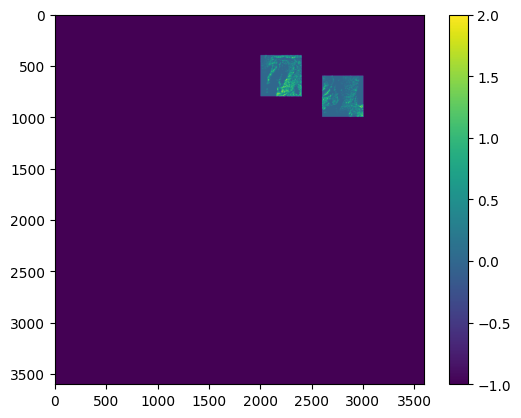

In [48]:
import matplotlib.pyplot as plt
import numpy as np
  
# Text file data converted to integer data type
File_data = np.loadtxt("viewshed_r3.txt", dtype=int)
print(File_data.shape)
plt.figure()
plt.imshow(File_data)
plt.colorbar()
plt.show()

In [55]:
%%cuda --name r2_parallel.cu

// We will only be using static arrays in this
#include <cuda.h>
#include <cuda_runtime.h>
#include <math.h>
#include <iostream>
#include <fstream>
#include <string>

const double INF_ = 1e9;
const double epsilon = 0.0000000001;

struct ii {
    int F;
    int S;
};

__device__ double calc_dist(ii p1, ii p2){
    double x1 = p1.F; double y1 = p1.S;
    double x2 = p2.F; double y2 = p2.S;
    double dx = x2-x1; double dy = y2-y1;
    return sqrt((dx*dx) + (dy*dy));
}


__device__ bool isvalid(ii p, int n, int m, double dist_from_origin, double range){
    if(p.F < 0 || p.S < 0) return 0;
    if(p.F >= n || p.S >= m) return 0;
    if(dist_from_origin > range) return 0;
    return 1;
}


__device__ double find_slope(int *grid, ii observer, ii curr, int observer_ht, int n, int m){
    double dist = calc_dist(observer, curr);
    int id_curr = (curr.F)*(m) + (curr.S);
    int id_obs = (observer.F)*(m) + (observer.S);
    double dh = double(grid[id_curr]) - (double(grid[id_obs]) + (double)observer_ht);
    double m_curr = dh/dist;
    return m_curr;
}


__device__  void plotPixel(ii *line, int &numpts, int x1, int y1, int x2, int y2, int dx, int dy, int decide, int lid_add){
    int pk = 2 * dy - dx;
    numpts = 0; 

    for (int i = 0; i <= dx; i++) {
        x1 < x2 ? x1++ : x1--;
        if (pk < 0) {
            if (decide == 0) {
                ii temp = {x1,y1};
                line[lid_add+numpts] = temp;
                numpts++;
                pk = pk + 2 * dy;
            }
            else {
                ii temp = {y1,x1};
                line[lid_add+numpts] = temp;
                numpts++;
                pk = pk + 2 * dy;
            }
        }
        else {
            y1 < y2 ? y1++ : y1--;
            if (decide == 0) {
                ii temp = {x1,y1};
                line[lid_add+numpts] = temp;
                numpts++;
            }
            else {
                ii temp = {y1,x1};
                line[lid_add+numpts] = temp;
                numpts++;
            }
            pk = pk + 2 * dy - 2 * dx;
        }
    }
}


__device__ void bresenham(ii *line_grid, int &numpts, int x1, int y1, int x2, int y2, int lid_add){
    int dx = abs(x2 - x1);
    int dy = abs(y2 - y1);
    numpts=0;
    if(dx > dy){
        plotPixel(line_grid, numpts, x1, y1, x2, y2, dx, dy, 0, lid_add);
    }
    else{
        plotPixel(line_grid, numpts, y1, x1, y2, x2, dy, dx, 1, lid_add);
    }
}


void readfile_and_make_grid(int* grid, int &n, int &m){
    //std::ifstream infile("/Users/avirajbevli/Desktop/Sem10/HPPP/cuda_term project/data/cdnf43w/heights.txt");
    std::cout<<"Reading from input file..."<<std::endl;
    std::ifstream infile("heights.txt");
    if(!infile.is_open()) {
        printf("not abel to read \n");
        std::cerr << "Error: Could not open read file" << std::endl;
        return  ;
    }

    std::string line;
    n=0;
    int numpts=0;
    while(std::getline(infile, line)) {
        std::string str; 
        int i=0;
        while(i<line.size()){
            if(line[i]==','){
                int temp = stoi(str);
                grid[numpts++] = temp;
                str="";
                i++;
            }
            else{
                str+=line[i];
            }
            i++;
        }
        n++;
    }
    m = (numpts)/n;
    infile.close();
    std::cout<<"Done reading \n"<<std::endl;
}


// cant rely on print in global
__global__ void test_kernel(int *viewshed_d, int *grid_d){
    viewshed_d[0]=999;
    grid_d[0]=999;
}

// -1: out of range, 0: not visible, 2: visible
// can not print anything inside global/device functions
__global__ void calculate_viewshed_and_writefile_r2(int *grid, int* viewshed, ii *line_grid, int n, int m, int range){    
    int obsy = 1000; int obsx = 2400;
    ii observer = {obsy, obsx}; //<y,x> or <row,col>
    int observer_ht = 10; // height of observer from the ground at <observer_x, observer_y>  

    int I,J;
    // int I = observer.F + (blockIdx.y * blockDim.y + threadIdx.y - range); 
    // int J = observer.S + (blockIdx.x * blockDim.x + threadIdx.x - range);
    if((blockIdx.x==0) || (blockIdx.x==1)){
        I = observer.F - range;
        if(blockIdx.x==0){
            J = observer.S - range + (threadIdx.x);
        }
        else{
            J = observer.S - range + (threadIdx.x) + (blockDim.x);
        }
    }
    else if((blockIdx.x==2) || (blockIdx.x==3)){
        J = observer.S + range;
        if(blockIdx.x==2){
            I = observer.F - range + (threadIdx.y);
        }
        else{
            I = observer.F - range + (threadIdx.y) + (blockDim.y);
        }
    }
    else if((blockIdx.x==4) || (blockIdx.x==5)){
        I = observer.F + range;
        if(blockIdx.x==4){
            J = observer.S + range - (threadIdx.x);
        }   
        else{
            J = observer.S + range - (threadIdx.x) - (blockDim.x);
        }   
    }
    else if((blockIdx.x==6) || (blockIdx.x==7)){
        J = observer.F - range;
        if(blockIdx.x==6){
            I = observer.F + range - (threadIdx.y);
        }
        else{
            I = observer.F + range - (threadIdx.y) - (blockDim.y);
        }
    }

    if(I>=0 && J>=0 && I<n && J<m){
        ii target = {I,J};
        int index = (target.F)*(m) + (target.S);
        viewshed[index]=1;
        __syncthreads(); // no need for this, right?
        
        double m_target = find_slope(grid, observer, target, observer_ht, n, m); 

        //size_t size_line_grid = (range + 1)*(8)*(2*range)*sizeof(ii);
        int linesz=0;
        // int tempy = blockIdx.y * blockDim.y + threadIdx.y;
        // int tempx = blockIdx.x * blockDim.x + threadIdx.x;
        // int lid_add = (tempy*(2*range + 1) + tempx)*(2*range); // range
        int lid_add = (blockIdx.x)*(2*range);
        bresenham(line_grid, linesz, observer.F, observer.S, target.F, target.S, lid_add);

        // printf("I:%d, J:%d, linesz:%d \n", I, J, linesz);
        double m_max = -INF_;
        for(int lid=1;lid<linesz-1;lid++){
            double m_curr = find_slope(grid, observer, line_grid[lid_add+lid], observer_ht, n, m);
            ii curr_pt = line_grid[lid_add+lid];
            int index_curr = (curr_pt.F)*(m) + (curr_pt.S);
            viewshed[index_curr] = 0;
            if(m_curr > m_max){
                viewshed[index_curr] = 1;
            }
            m_max = max(m_max, m_curr);
        }
        if(m_max > m_target + epsilon){
            viewshed[index]=0;
        }
        __syncthreads(); // so that the viewshed is complete
    }
}



int main(){
    cudaError_t err = cudaSuccess;
    int n=3600; int m=3600;
    int range = 800;
    size_t size = (3600*3600)*sizeof(int);
    // allocating a 2 dim kernel sizes 


    dim3 gridDim(2*range+2, 1, 1);
    dim3 blockDim(8, 1, 1); 

    int *grid_h = (int *)malloc(size);
    if (grid_h == NULL) { // check if memory allocation was successful
        printf("Memory allocation to grid failed.");
        return 1;
    }
    readfile_and_make_grid(grid_h,n,m);
    printf("read input file grid_0: %d \n", grid_h[0]);

    int *grid_d = NULL;
    cudaMalloc((void **) &grid_d, size);
    if (err != cudaSuccess){
        printf("FAIL");
        fprintf(stderr, "Failed to allocate device grid (error code %s)!\n", cudaGetErrorString(err));
        exit(EXIT_FAILURE);
    }
  
    int *viewshed_h = (int *)malloc(size);
    for(int i =0;i<n;i++){
        for(int j=0;j<m;j++){
            viewshed_h[i*m+j] = -1;
        }
    }

    int *viewshed_d = NULL;
    cudaMalloc((void **) &viewshed_d, size);
    if (err != cudaSuccess){
        printf("FAIL");
        fprintf(stderr, "Failed to allocate device viewshed (error code %s)!\n", cudaGetErrorString(err));
        exit(EXIT_FAILURE);
    }

    ii *line_grid = NULL;
    size_t size_line_grid = (range + 1)*(8)*(2*range)*sizeof(ii);
    cudaMalloc((void **) &line_grid, size_line_grid);
    if (err != cudaSuccess){
        printf("FAIL");
        fprintf(stderr, "Failed to allocate device viewshed (error code %s)!\n", cudaGetErrorString(err));
        exit(EXIT_FAILURE);
    }
    
    err = cudaMemcpy(grid_d, grid_h, size, cudaMemcpyHostToDevice);
    if (err != cudaSuccess){
        fprintf(stderr, "Failed to copy grid from host to device (error code %s)!\n", cudaGetErrorString(err));
        exit(EXIT_FAILURE);
    }

    err = cudaMemcpy(viewshed_d, viewshed_h, size, cudaMemcpyHostToDevice);
    if (err != cudaSuccess){
        fprintf(stderr, "Failed to copy viewshed from host to device (error code %s)!\n", cudaGetErrorString(err));
        exit(EXIT_FAILURE);
    }

    printf("before kernel call, viewshed_0: %d, grid_0: %d \n", viewshed_h[0], grid_h[0]);
    calculate_viewshed_and_writefile_r2<<<gridDim, blockDim>>>(grid_d, viewshed_d, line_grid, n, m, range);
    err = cudaGetLastError();
    if (err != cudaSuccess){
        fprintf(stderr, "Failed to launch kernel (error code %s)!\n", cudaGetErrorString(err));
        exit(EXIT_FAILURE);
    }
    err = cudaMemcpy(viewshed_h, viewshed_d, size, cudaMemcpyDeviceToHost);
    if (err != cudaSuccess){
        fprintf(stderr, "Failed to copy viewshed from device to host (error code %s)!\n", cudaGetErrorString(err));
        exit(EXIT_FAILURE);
    }
    printf("after kernel call, viewshed_0: %d, grid_0: %d \n", viewshed_h[0], grid_h[0]);


    std::cout<<"Writing to output viewshed file ...."<<std::endl;
    std::ofstream outFile("viewshed_r3.txt");   
    if (!outFile.is_open()) {
        std::cout << "Unable to open write file" << std::endl;
        return;
    }

    for(int i=0;i<n*m;i++){
        outFile<<viewshed_h[i]<<" ";
        if((i%m)==m-1){
            outFile<<std::endl;
        }
    }
    // Close the file
    outFile.close();
    std::cout<<"Done writing"<<std::endl;  

    // free device memory
    err = cudaFree(grid_d); 
    if (err != cudaSuccess){
        fprintf(stderr, "Failed to free device grid (error code %s)!\n", cudaGetErrorString(err));
        exit(EXIT_FAILURE);
    }
    err = cudaFree(viewshed_d); 
    if (err != cudaSuccess){
        fprintf(stderr, "Failed to free device grid (error code %s)!\n", cudaGetErrorString(err));
        exit(EXIT_FAILURE);
    }

    // reset the device and exit
    err = cudaDeviceReset();
    if (err != cudaSuccess){
        fprintf(stderr, "Failed to deinitialize the device! error=%s\n", cudaGetErrorString(err));
        exit(EXIT_FAILURE);
    }

    //free host memory
    free(grid_h);
    free(viewshed_h);
    printf("Done \n");
    return 0;
}

'File written in /content/src/r2_parallel.cu'

In [56]:
!nvcc /content/src/r2_parallel.cu -o /content/src/r2_parallel
!nvcc -arch=sm_75 -gencode=arch=compute_75,code=sm_75 /content/src/r2_parallel.cu -o /content/src/r2_parallel
!/content/src/r2_parallel 
!nvprof /content/src/r2_parallel 

Reading from input file...
Done reading 

read input file grid_0: 227 
before kernel call, viewshed_0: -1, grid_0: 227 
after kernel call, viewshed_0: -1, grid_0: 227 
Writing to output viewshed file ....
Done writing
Done 
Reading from input file...
Done reading 

read input file grid_0: 227 
==41294== NVPROF is profiling process 41294, command: /content/src/r2_parallel
before kernel call, viewshed_0: -1, grid_0: 227 
after kernel call, viewshed_0: -1, grid_0: 227 
Writing to output viewshed file ....
Done writing
Done 
==41294== Profiling application: /content/src/r2_parallel
==41294== Profiling result:
            Type  Time(%)      Time     Calls       Avg       Min       Max  Name
 GPU activities:   59.56%  23.362ms         2  11.681ms  11.441ms  11.920ms  [CUDA memcpy HtoD]
                   27.41%  10.751ms         1  10.751ms  10.751ms  10.751ms  [CUDA memcpy DtoH]
                   13.03%  5.1112ms         1  5.1112ms  5.1112ms  5.1112ms  calculate_viewshed_and_writefile_r2(

(3600, 3600)


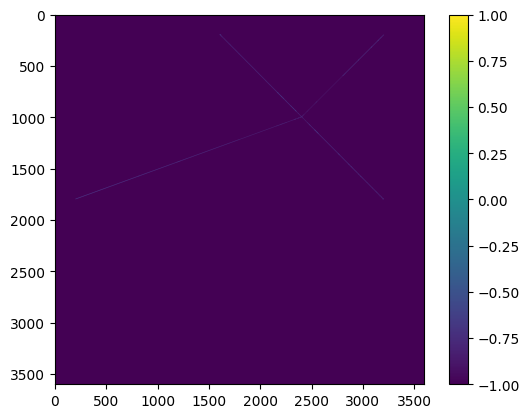

In [57]:
import matplotlib.pyplot as plt
import numpy as np
  
# Text file data converted to integer data type
File_data = np.loadtxt("viewshed_r3.txt", dtype=int)
print(File_data.shape)
plt.figure()
plt.imshow(File_data)
plt.colorbar()
plt.show()